In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scripts.openfiles import *
from tqdm import tqdm
from IPython.display import clear_output

from newinstruments.mcc_daq import *
from pymeasure.instruments.srs import sr844, sr830
from pymeasure.instruments.agilent import Agilent33500
from pymeasure.instruments.yokogawa import yokogawa7651, yokogawaGS200

In [3]:
yoko_Lch     = yokogawaGS200.YokogawaGS200('GPIB1::7::INSTR')
yoko_pinch     = yokogawaGS200.YokogawaGS200('GPIB1::1::INSTR')
yoko_Lchgt    = yokogawaGS200.YokogawaGS200("GPIB1::21::INSTR")
yoko_gtAll    = yokogawaGS200.YokogawaGS200("GPIB1::6::INSTR")
yoko_res    = yokogawa7651.Yokogawa7651("GPIB1::3::INSTR")

filament    = Agilent33500("GPIB1::17::INSTR")
lockin_HF   = sr844.SR844('GPIB1::11::INSTR')
daq         = mcc_daq()

generator   = Agilent33500("GPIB1::19::INSTR")

In [4]:
filament.output = 'off'

lockin_HF.time_constant = 0.1      # corresponds to 100 ms
generator.amplitude = 0.1
generator.frequency = 3e6
lockin_HF.sensitivity = 0.03


print(f"lockin sensitivity is {lockin_HF.sensitivity}") # in Volts
daq.device_detect()

lockin sensitivity is 0.03
Found 1 DAQ device(s):
  USB-1602HS (1000030) - Device ID = 213

Active DAQ device: USB-1602HS (1000030)



In [160]:
# PULSE

filament.output = 'off'

amp = 1.6
tau = 0.25  #0.5

filament.shape ='PULS'
filament.amplitude = amp
filament.offset = -amp/2
filament.frequency = 1/(2*tau)
filament.pulse_width = tau

filament.burst_mode ='TRIG'
filament.burst_ncycles = 1
filament.burst_state = True

filament.trigger_source = 'BUS'
filament.trigger_delay = 0.5

filament.output_polarity = 'INV'

daq.measurement_time = 2 * tau
daq.sampling_rate = 100_000
daq.voltage_range = 0
daq.status = True

In [95]:
# SQUARE

filament.output = 'off'

amp = 1.6
f = 0.2

filament.shape ='SQU'
filament.amplitude = amp
filament.offset = -amp/2
filament.frequency = f
#filament.polarity = 'INV'
filament.square_dutycycle = 80

filament.burst_mode ='TRIG'
filament.burst_ncycles = 1
filament.burst_state = True

filament.trigger_source = 'BUS'
#filament.trigger_delay = 0.5

#filament.output_polarity = 'INV'

daq.measurement_time = 2 # 2 * tau
daq.sampling_rate = 100_000
daq.voltage_range = 0
daq.status = True

In [161]:
def set_prefilament_cond() -> None:
    generator.output = 'on'
    generator.amplitude = 1.0
    yoko_gt.ramp_to_voltage(0, duration=1)
    yoko_ch.ramp_to_voltage(0.0, duration=1) # 0.2
    yoko_g14.ramp_to_voltage(0.0, duration=1) # 0.2
    yoko_g23.ramp_to_voltage(0.0, duration=1) # 0.2
    yoko_res.enable_source()
    yoko_res.ramp_to_voltage(-0.8, duration=1)
    sleep(5)
    yoko_res.ramp_to_voltage(1.2, duration=1) #1.2
    sleep(1)

def set_presweep_cond(Vch=0.0, Vres=0.8) -> None:
    yoko_gt.ramp_to_voltage(0.0, duration=1)
    yoko_ch.ramp_to_voltage(Vch, duration=1)
    yoko_g14.ramp_to_voltage(Vch, duration=1)
    yoko_g23.ramp_to_voltage(Vch, duration=1)
    yoko_res.ramp_to_voltage(Vres, duration=1)
    sleep(2)

def generate_electrons() -> tuple:
    filament.output = 'on'
    print('filament turned on')
    sleep(0.2) #0.3
    filament.trigger()
    print('scan started')
    output = daq.scan()
    filament.output = 'off'
    print('filament turned off')
    return output

In [169]:
set_prefilament_cond()

In [163]:
tlist, data = generate_electrons()

filament turned on
scan started
Scan completed successfully.
Data copied from buffer - complete.
filament turned off


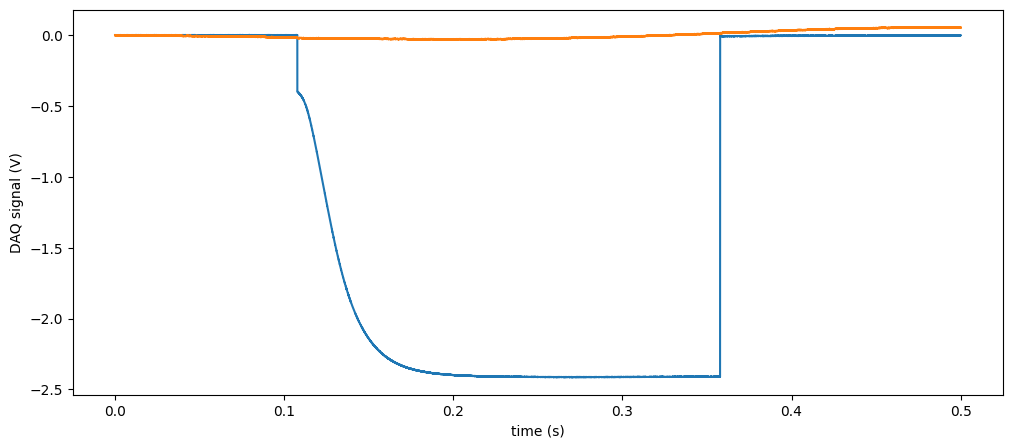

In [164]:
plt.figure(figsize=(12,5))
plt.plot(tlist,data[:,0])
plt.plot(tlist,1*(data[:,1] - np.average(data[:100,1])))
plt.xlabel('time (s)')
plt.ylabel('DAQ signal (V)')
#plt.xlim(0.3, 2.0)
plt.show()

### **1D sweep**

In [165]:
sweep_num = 81
sweep_list = np.linspace(0.0, 2.0, num=sweep_num, endpoint=True)
step_num = 1

data_x = np.zeros((sweep_num, step_num))
data_y = np.zeros((sweep_num, step_num))

In [166]:
generator.frequency = 1.1e6
generator.amplitude = 0.9

set_presweep_cond(Vch=0.0, Vres=0.5)

In [167]:
yoko_gt.ramp_to_voltage(0, duration=1)
try:
    for i, V in enumerate(tqdm(sweep_list, ncols=80)):
    
        yoko_ch.source_voltage = V
        yoko_g14.source_voltage = V
        yoko_g23.source_voltage = V
        time.sleep(0.3)

        data_x[i] = lockin_HF.x
        data_y[i] = lockin_HF.y

except KeyboardInterrupt:
    print('data acquisition is interrupted by user')

100%|███████████████████████████████████████████| 81/81 [00:27<00:00,  2.96it/s]


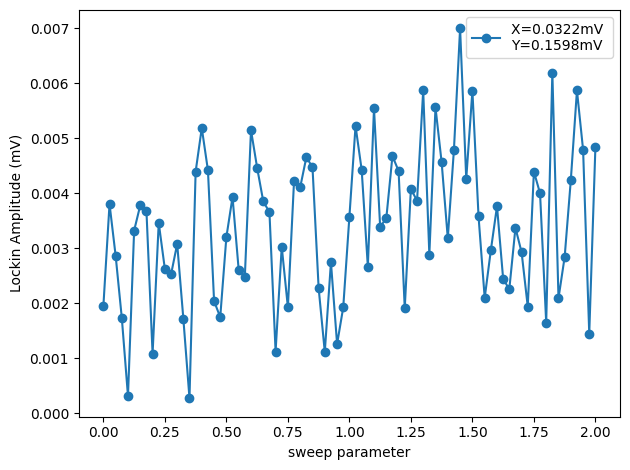

In [168]:
offset_x = np.average(data_x[1:8])
offset_y = np.average(data_y[1:8])

signal = 1e3*np.sqrt((data_x[:] - offset_x)**2 + (data_y[:] - offset_y)**2)
plt.plot(sweep_list, signal, '-o', label=f'X={round(offset_x*1e3, 4)}mV \nY={round(offset_y*1e3, 4)}mV')
plt.ylabel('Lockin Amplitude (mV)')
plt.xlabel('sweep parameter')
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
filament.check_errors()

In [ ]:
MSa = 1e5
total_time = 0.15
Ntotal = int(MSa * total_time)

on_time = 0.1
raise_time = 0.1 * on_time
fall_time = 0.1 * on_time

ti = (total_time - on_time)/2
Np = 13

N1 = int(ti * MSa)
N2 = int(raise_time * MSa)
N4 = int(fall_time * MSa)
N3 = int((on_time - raise_time - fall_time) * MSa)
N3i = int(N3/Np)
N5 = Ntotal - N1 - N2 - N3 - N4

print(N1, N2, N3, N4, Np, N3i, N5)

In [ ]:
amp_pulse_A = -32767
amp_pulse_B = int(0.9 * amp_pulse_A)
arb_data = np.zeros(Ntotal)
arb_data[N1:N1 + N2] = np.round(np.linspace(0, amp_pulse_A, num=N2))
for i in range(Np):
    Ns1 = N1 + N2 + i * N3i
    Ns2 = Ns1 + N3i
    arb_data[Ns1:Ns2] = (1 - np.cos(2 * np.pi * np.arange(N3i)/N3i)) * (amp_pulse_B - amp_pulse_A) + amp_pulse_A
arb_data[Ns2:Ns2 + N4] = np.round(np.linspace(amp_pulse_A, 0, num=N4))

plt.plot(arb_data)
plt.show()

In [ ]:
filament.data_volatile_clear()
filament.shape = 'ARB'
filament.data_arb('fire', arb_data.astype(int), data_format='DAC')
amp = 1.6
filament.amplitude = amp


filament.burst_mode ='TRIG'
filament.burst_ncycles = 1
filament.burst_state = True
filament.trigger_source = 'IMM'

In [ ]:
# PULSE Signal

amp = 1.6
tau = 0.1

filament.shape ='PULS'
filament.amplitude = amp
filament.offset = -amp/2
filament.polarity = 'INV'
filament.frequency = 1/(2*tau)
filament.pulse_width = tau
filament.pulse_transition = 1e-6
#filament.pulse_dutycycle = 60